In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
import importlib
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

In [4]:
### morning data
with open('data/preprocess/m_data_list.pkl', 'rb') as f:
#with open('data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/e_data_list.pkl', 'rb') as f:
#with open('data/preprocess/full_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [5]:
# load model
model = LSTMModel_cycle(input_size = 10, hidden_size = 32, no_time_size = 3).to(device)
# set model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

In [7]:
# Train model
num_epochs  = 800
'''
train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}
'''

for t in range(800, 800 + num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()  
    # Forward pass
    train_pred = model(train_time, train_notime)
    loss = criterion(train_pred, train_y[:,:,1])
    train_error.append(loss)

    valid_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        best_model = model

    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

800 Epochs train MSE: 0.03003 // valid MSE: 0.04332
810 Epochs train MSE: 0.02983 // valid MSE: 0.04333
820 Epochs train MSE: 0.02963 // valid MSE: 0.04303
830 Epochs train MSE: 0.03131 // valid MSE: 0.04464
840 Epochs train MSE: 0.02936 // valid MSE: 0.04127
850 Epochs train MSE: 0.03405 // valid MSE: 0.04288
860 Epochs train MSE: 0.02947 // valid MSE: 0.04444
870 Epochs train MSE: 0.02845 // valid MSE: 0.04319
880 Epochs train MSE: 0.02877 // valid MSE: 0.04395
890 Epochs train MSE: 0.02867 // valid MSE: 0.04206
900 Epochs train MSE: 0.02908 // valid MSE: 0.04367
910 Epochs train MSE: 0.02812 // valid MSE: 0.04387
920 Epochs train MSE: 0.02945 // valid MSE: 0.04195
930 Epochs train MSE: 0.03005 // valid MSE: 0.04380
940 Epochs train MSE: 0.02944 // valid MSE: 0.04462
950 Epochs train MSE: 0.02791 // valid MSE: 0.04237
960 Epochs train MSE: 0.03014 // valid MSE: 0.04481
970 Epochs train MSE: 0.02868 // valid MSE: 0.04329
980 Epochs train MSE: 0.03012 // valid MSE: 0.04224
990 Epochs t

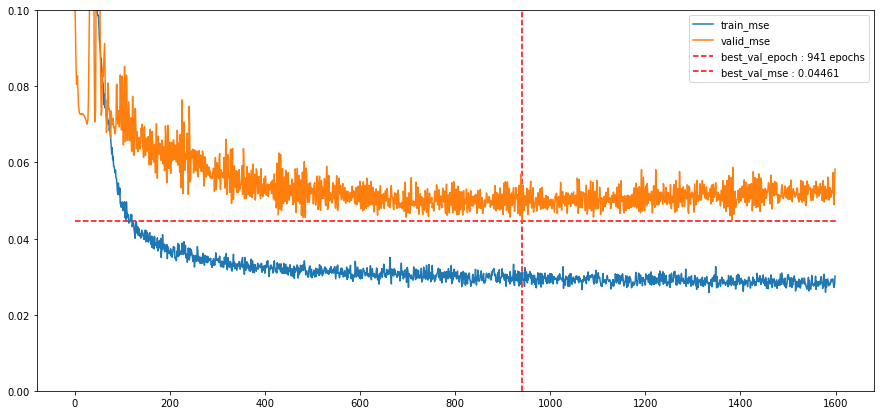

In [6]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가
# lstm층을 쌓고 (2개) dropout추가 -> 그닥

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

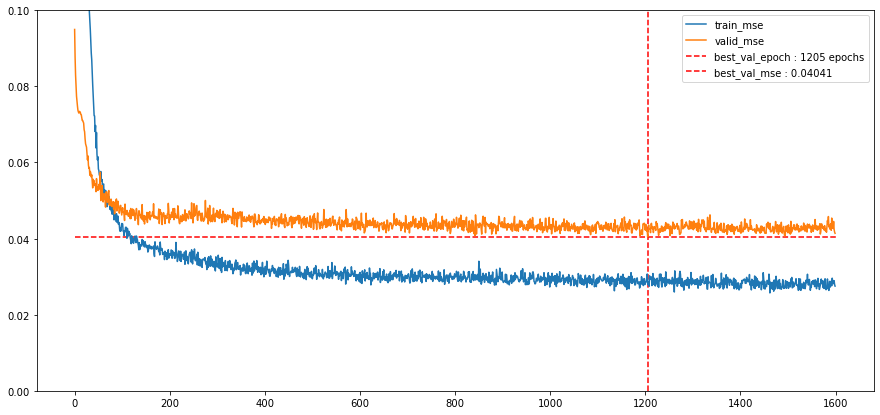

In [8]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# merge층을 추가하고 dropout도 추가 가장 성능 좋음

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

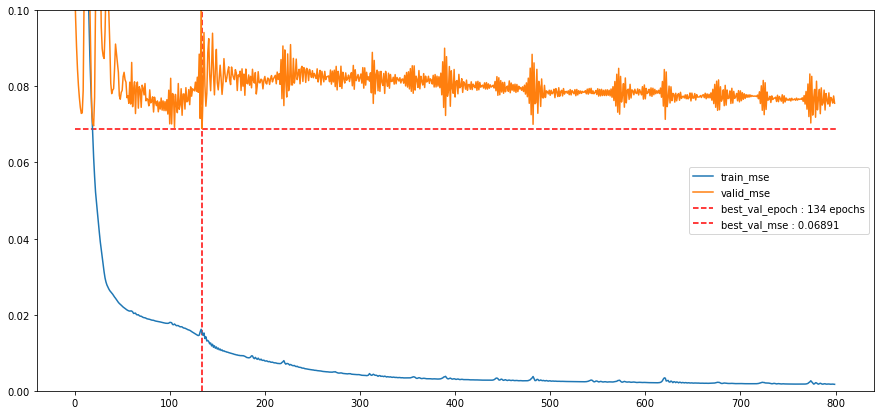

In [8]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# time fc층을 추가했더니 성능이 떨어짐

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

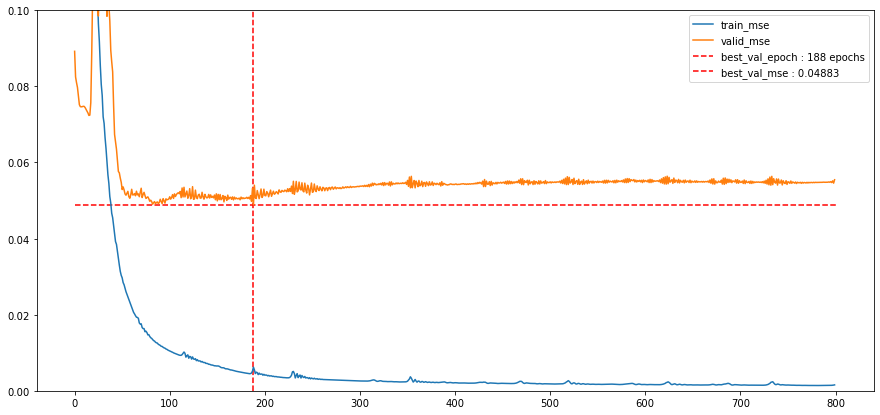

In [9]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# notime에 dropout추가
# 가장 최저 오차는 올랐지만 학습이 좀더 안정적

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

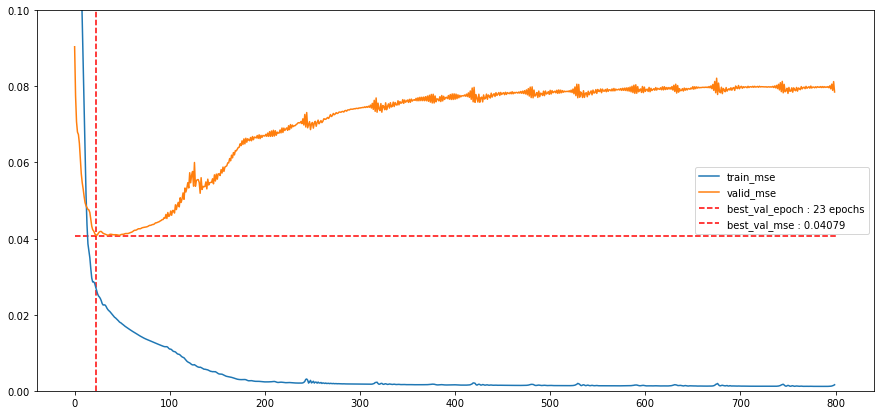

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data만 사용
# hiddensize = 32
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

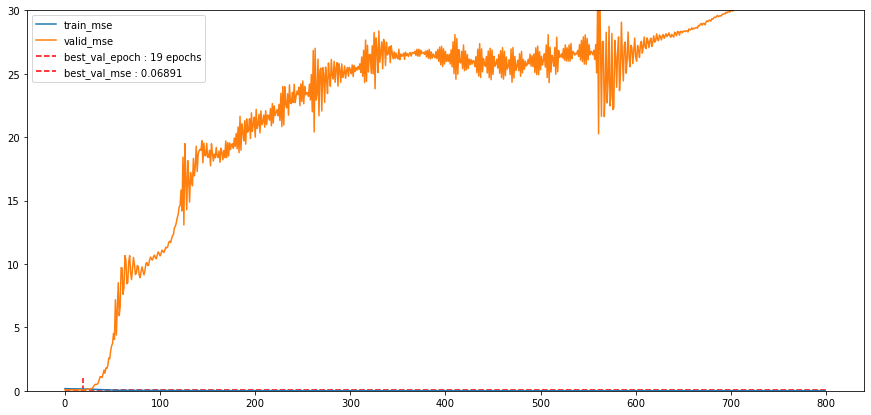

In [8]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# 요일정보 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,30)
plt.show()

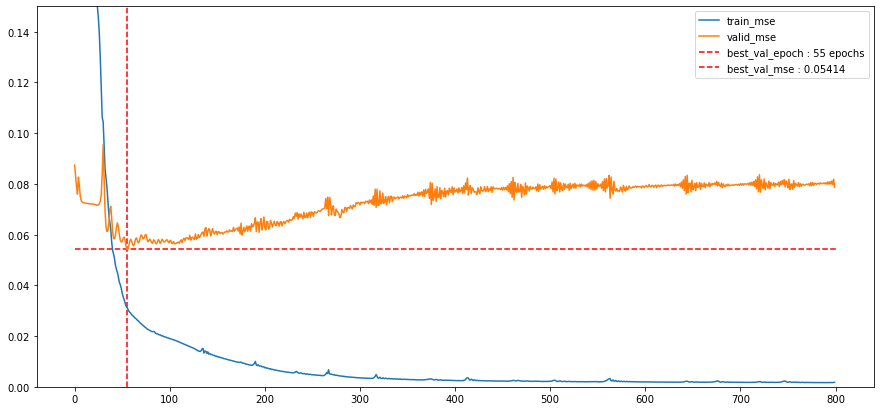

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# dayofyear만 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.15)
plt.show()

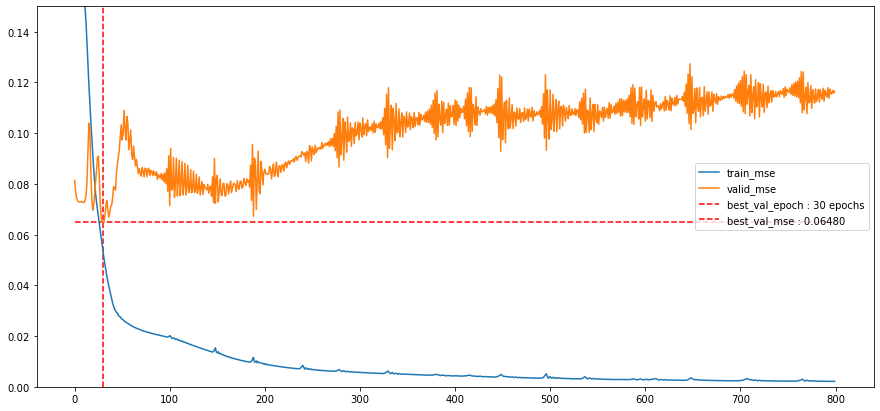

In [6]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# 공휴일만 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.15)
plt.show()

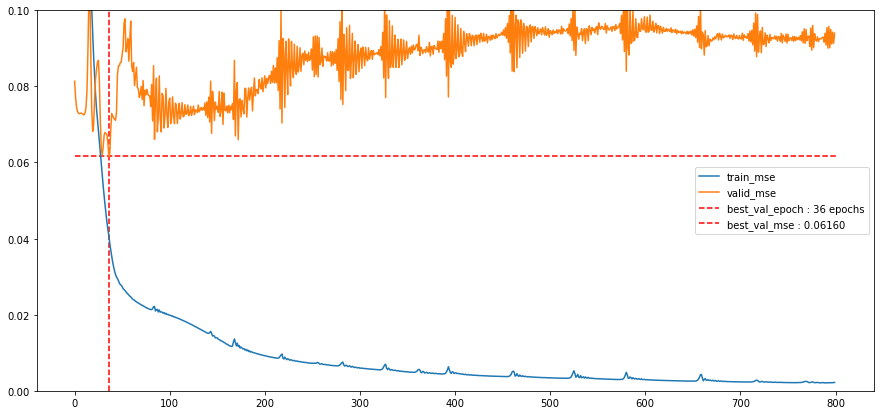

In [7]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32
# 코로나만 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

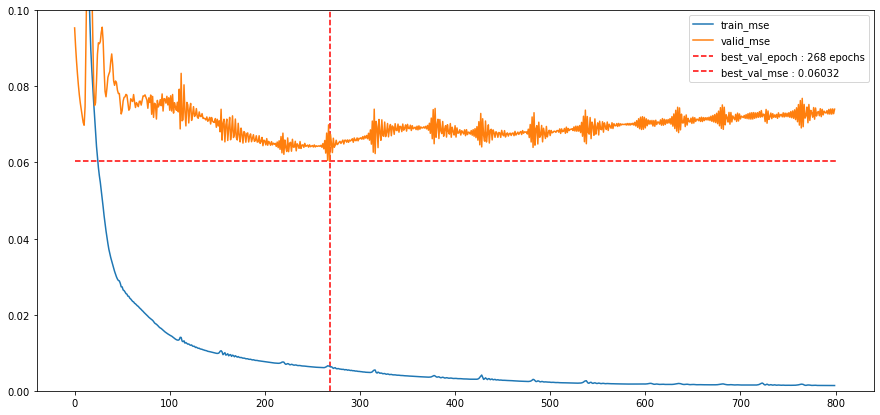

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32

# 온도, 섭도, 강수량 제거

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

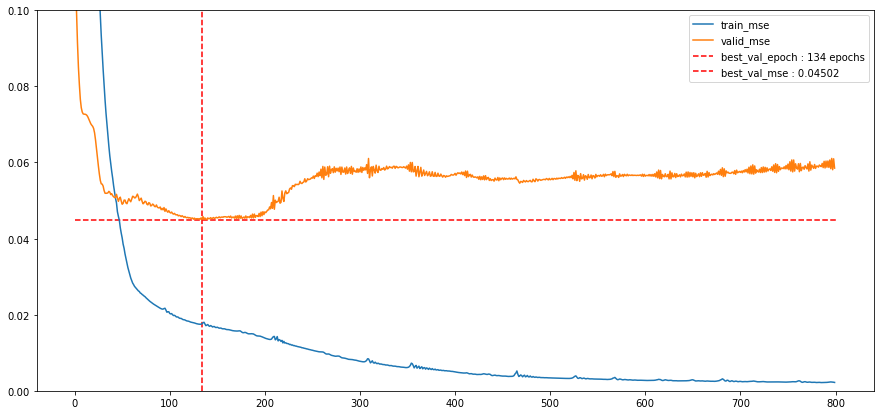

In [6]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.1)
plt.show()

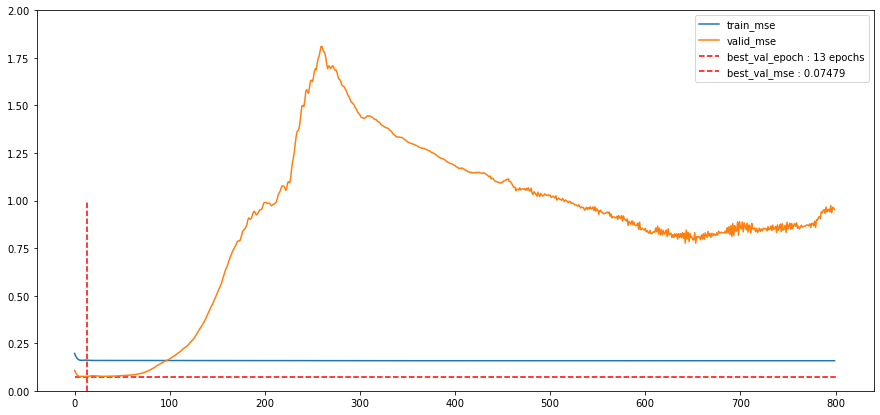

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  인코딩 후 fc
# hiddensize = 32

# 초 오버피팅

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,2)
plt.show()

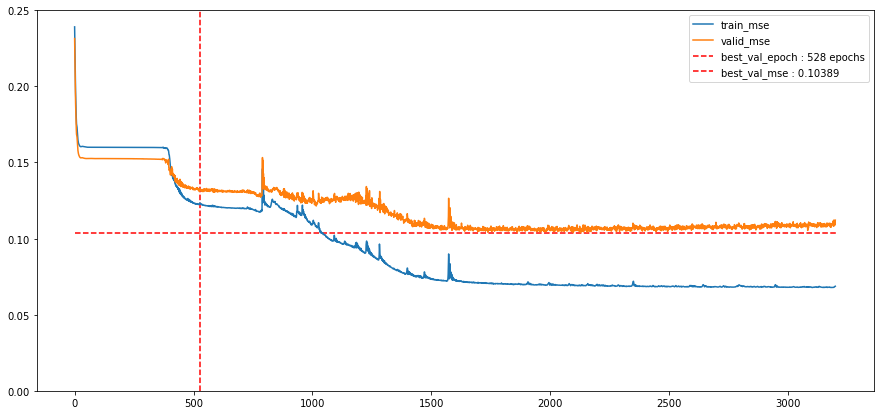

In [9]:
# cycle을 추출할 때 rolling을 21로 사용
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
#  seq2seq모델을 사용
# hiddensize = 32
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

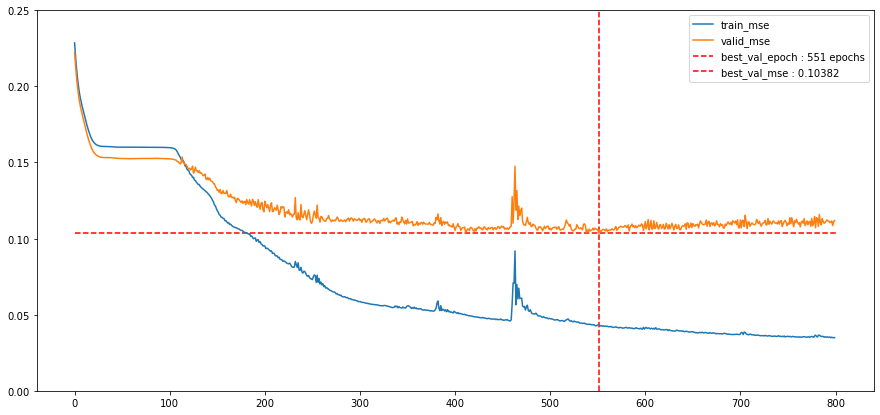

In [5]:
# cycle을 추출할 때 rolling을 21로 사용
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
# hiddensize = 16
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

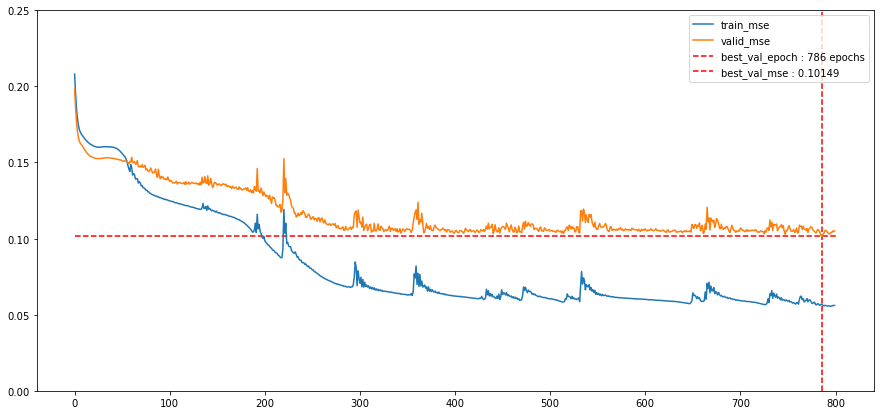

In [5]:
# cycle을 추출할 때 rolling을 21로 사용

# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

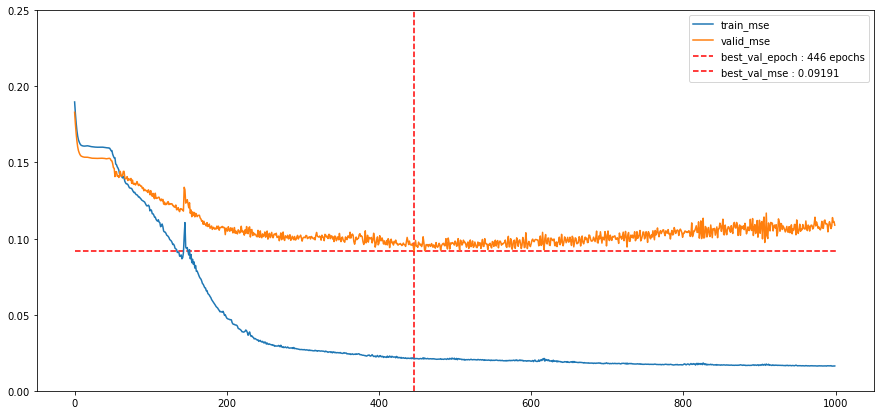

In [6]:
# cycle을 추출할 때 rolling을 21로 사용

# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 1000,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

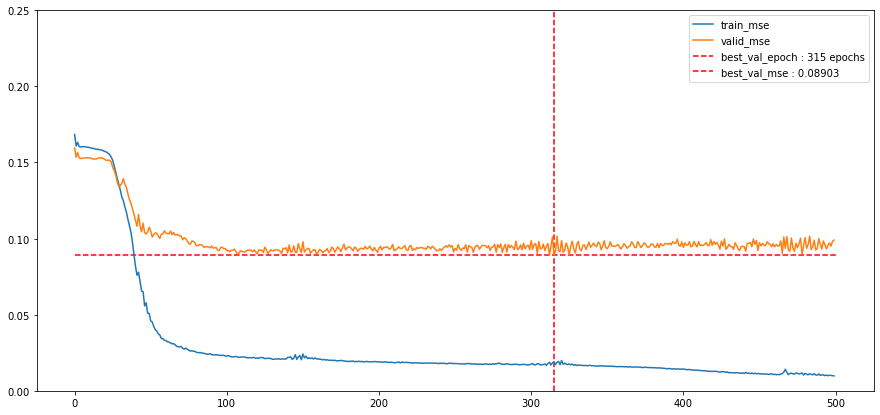

In [11]:
# cycle을 추출할 때 rolling을 21로 사용

# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

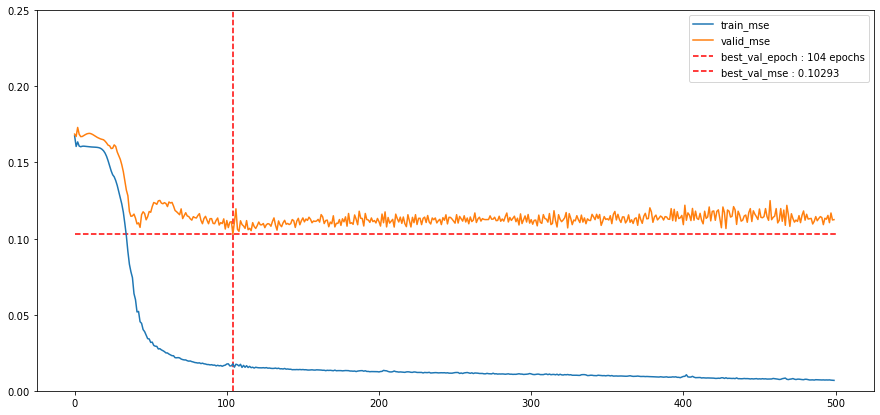

In [7]:
#ROLLING = 7

# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
#train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data 만 사용
# lstm 층 4개 통과, drop out 층 추가
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

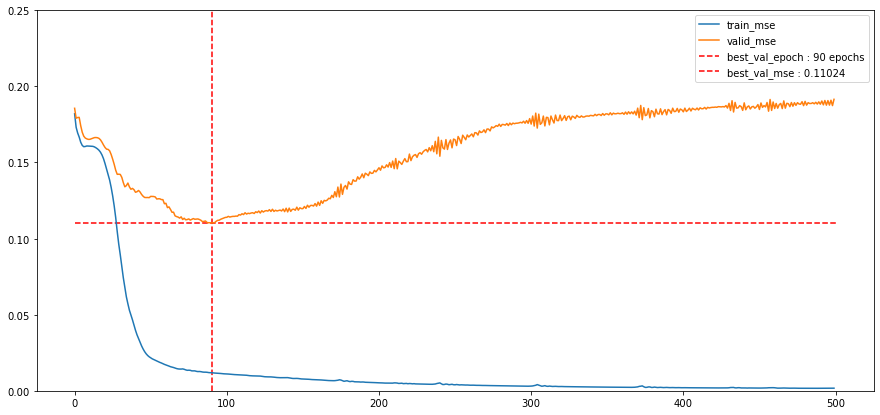

In [5]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data 사용
# time을 lstm에 넣기 전에 notime을 곱해줌
# lstm 층 2개 통과
# 마지막 notime 을 3->3->3->1로
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

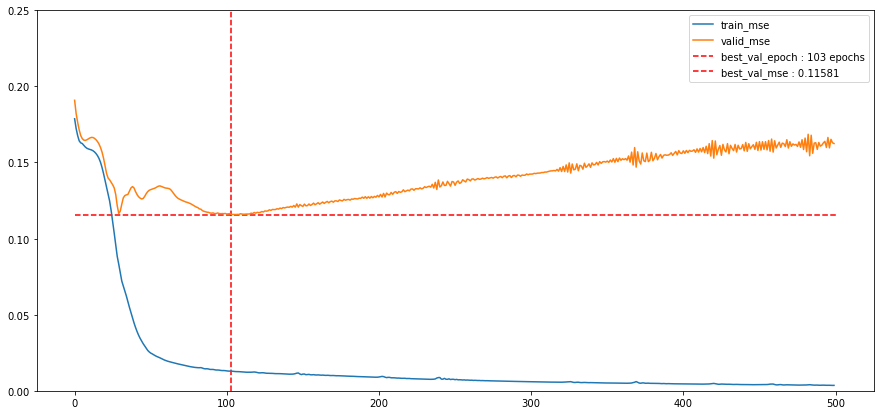

In [6]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data 사용
# time을 lstm에 넣기 전에 notime을 곱해줌
# 마지막 notime 을 3->3->3->1로
# 마지막 output 을 32 -> 7
# 그러고 출력
plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

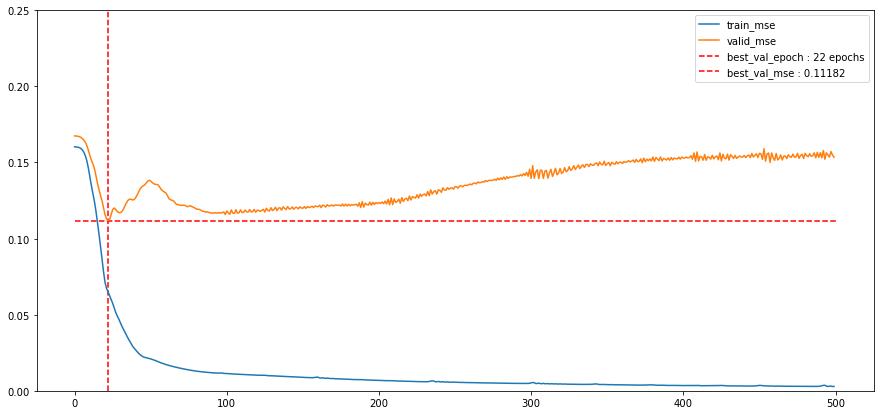

In [5]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data 사용
# 마지막 output 을 32 -> 7
# 마지막 notime 을 3->3->3->1로
# 7개의 output에 notime을 곱

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

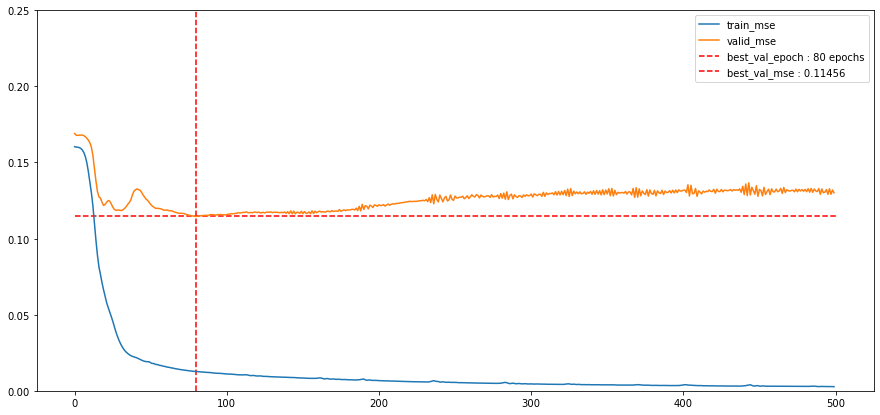

In [5]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data, no time data 사용
# 마지막 output 을 32 -> 7
# 마지막 notime 을 3 ->32->16->8->4 1로

# 7개의 output에 notime을 곱


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

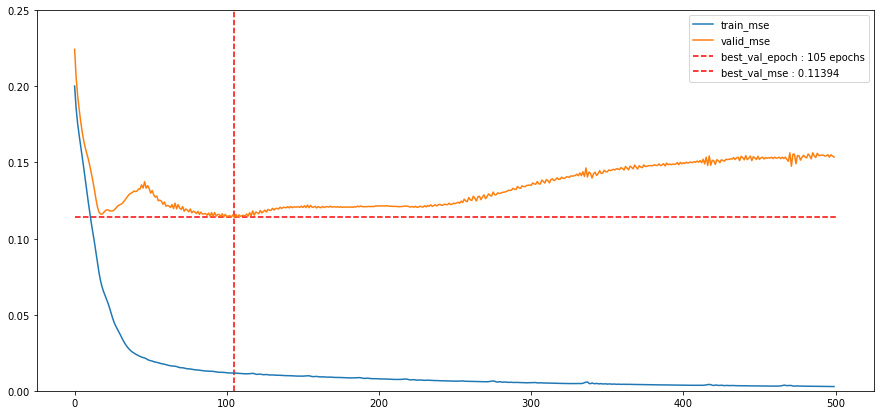

In [5]:
# train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
# time data만 사용한 모델
# 마지막 output 을 32 -> 7 nn하여 출력

plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

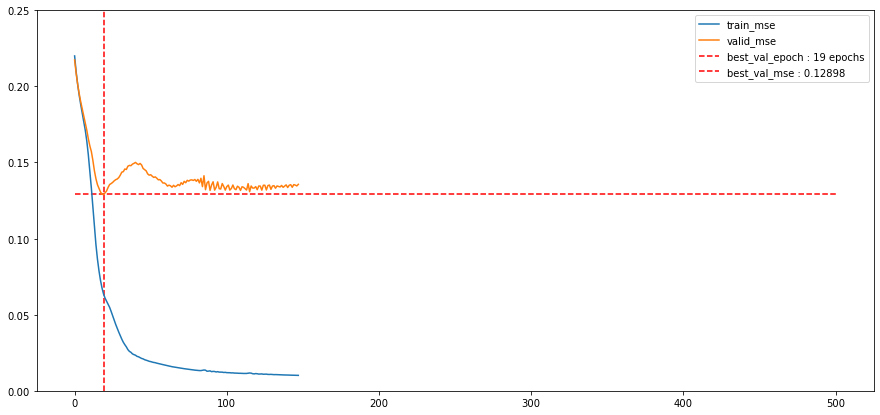

In [26]:
# train 모든 데이터로 scaler학습
#  기본 모델


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

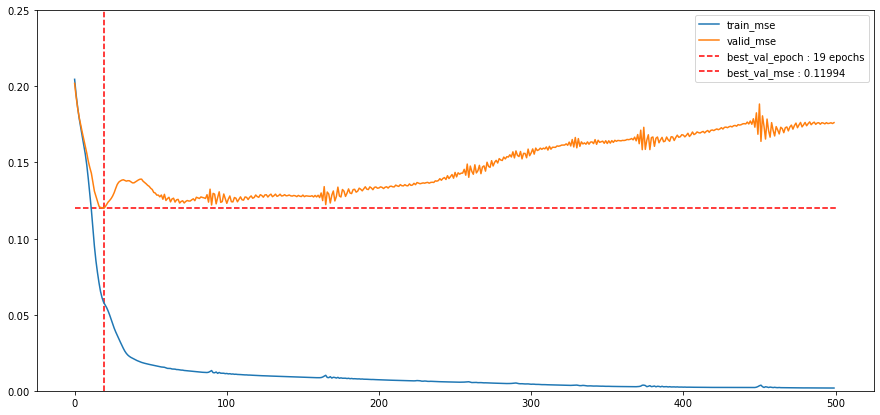

In [9]:
#  train에서 80 % 랜덤 추출 데이터로만 스케일러 학습
#  기본 모델


plt.figure(figsize = [15, 7])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')

plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = 500,
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")

plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.25)
plt.show()

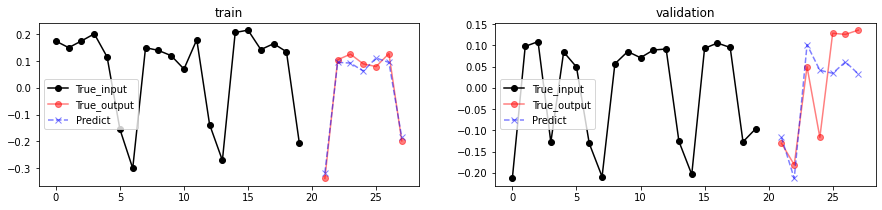

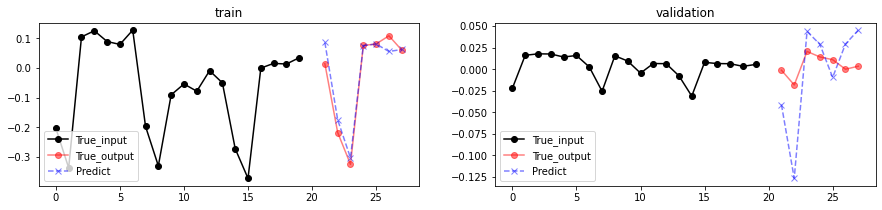

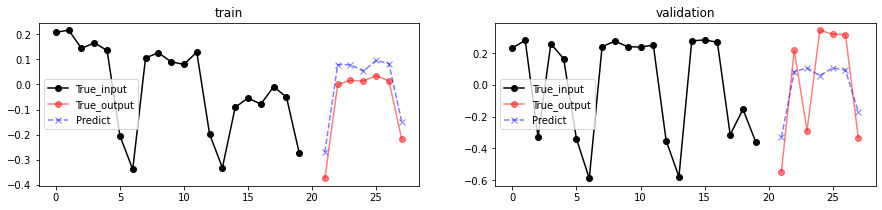

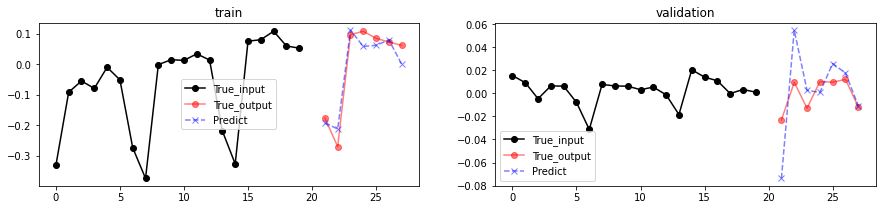

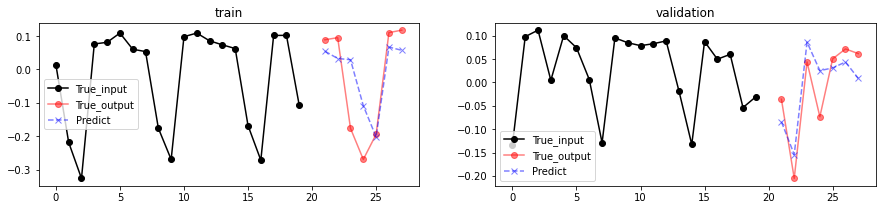

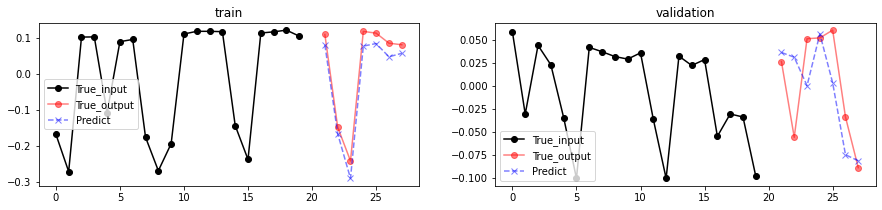

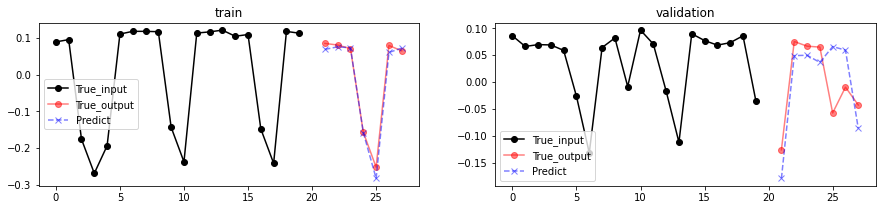

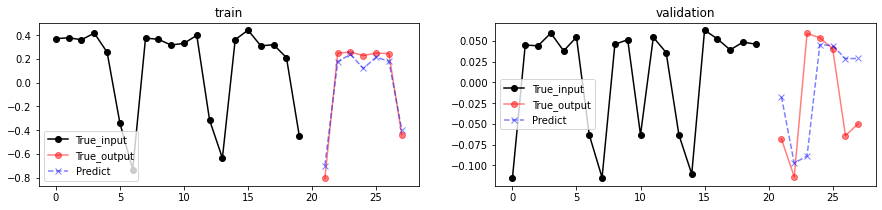

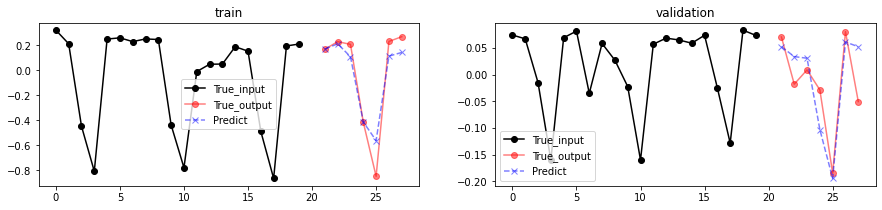

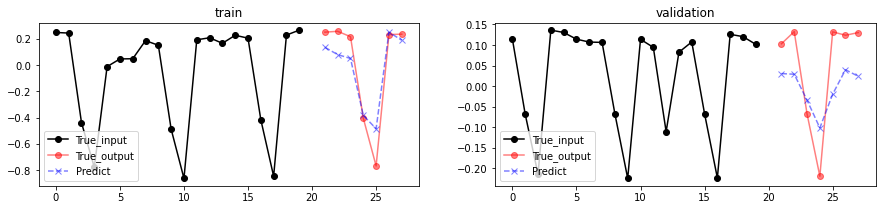

In [8]:
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])
# plot result
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    valid_time_x_np, valid_y_np, valid_pred_np]
### morning result
path = 'data/train_results/'
with open(path + 'm_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)